In [1]:
import torch.jit
import time
from argparse import ArgumentParser
import numpy as np
import torch


import dlrm.scripts.utils as utils
from dlrm.data.data_loader import get_data_loaders
from dlrm.data.utils import get_categorical_feature_sizes, prefetcher
from dlrm.model.single import Dlrm
from dlrm.utils.checkpointing.serial import SerialCheckpointWriter, make_serial_checkpoint_writer, \
    make_serial_checkpoint_loader

Using the Volta-optimized dot interaction kernels


In [2]:
!cat /data/dlrm/binary_dataset/model_size.json

{
    "_c2": 138493,
    "_c3": 26744
}

In [3]:
import pandas as pd

users_mapping = pd.read_parquet('/data/dlrm/spark/output/models/2.parquet',engine='pyarrow')

In [4]:
users_mapping.shape

(138493, 3)

In [5]:
users_mapping

,data,id,model_count
0,14332,130905,641
1,79216,130906,641
2,112063,130907,641
3,130100,130908,641
4,29772,130909,641
5,23637,130910,641
6,126529,130911,641
7,63008,130912,641
8,6780,130913,641
9,136719,130914,641


In [6]:
(905-20)*138493 

122566305

In [7]:
5050*26744 

135057200

In [8]:
items_mapping = pd.read_parquet('/data/dlrm/spark/output/models/3.parquet',engine='pyarrow')

In [9]:
items_mapping.sort_values(by='model_count',  ascending=False)

,data,id,model_count
26735,296,1,73508
26736,356,2,72111
26737,318,3,70577
26738,593,4,69924
26739,480,5,66538
26740,110,6,61959
26741,260,7,61789
26742,589,8,60295
26743,527,9,59151
18192,457,10,58794


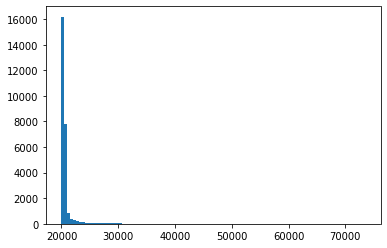

In [10]:
import matplotlib.pyplot as plt
plt.hist(items_mapping['model_count'],100);

In [11]:
np.max(items_mapping['id'])

26744

In [12]:
np.sum(items_mapping['model_count'])

556298482

In [13]:
np.sum(users_mapping['model_count'])

556298482

In [14]:
class flag(object):
    def __init__(self):
        
        # Model configuration
        self.embedding_type = "joint" # The type of the embedding operation to use")
        self.embedding_dim = 128 # "Dimensionality of embedding space for categorical features")
        self.top_mlp_sizes = [1024, 1024, 512, 256, 1] # "Linear layer sizes for the top MLP")
        self.bottom_mlp_sizes = [512, 256, 128] #Linear layer sizes for the bottom MLP")

        self.interaction_op ="cuda_dot" #"Type of interaction operation to perform.")

        self.dataset = "/data/dlrm/binary_dataset/"
        self.dataset_type = "split" #The type of the dataset to use')

        self.base_device = "cuda" #"Device to run the majority of the model operations")
        self.amp = False #If True the script will use Automatic Mixed Precision")
        self.optimized_mlp = True #Use an optimized implementation of MLP from apex")
        self.max_table_size = None #Maximum number of rows per embedding table, by default equal to the number of unique values for each categorical variable")
        self.num_numerical_features = 1
        self.hash_indices = False

In [15]:
FLAGS = flag()

print("Creating model")

model_config = {
    'top_mlp_sizes': FLAGS.top_mlp_sizes,
    'bottom_mlp_sizes': FLAGS.bottom_mlp_sizes,
    'embedding_type': FLAGS.embedding_type,
    'embedding_dim': FLAGS.embedding_dim,
    'interaction_op': FLAGS.interaction_op,
    'categorical_feature_sizes': get_categorical_feature_sizes(FLAGS),
    'num_numerical_features': FLAGS.num_numerical_features,
    'hash_indices': FLAGS.hash_indices,
    'use_cpp_mlp': FLAGS.optimized_mlp,
    'fp16': FLAGS.amp,
    'base_device': FLAGS.base_device,
}

model = Dlrm.from_dict(model_config)
print(model)

Creating model
feature sizes:  [138494, 26745]
Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 138494 165239]
      (embedding): Embedding(165239, 128, sparse=True)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [1, 512, 256, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [132, 1024, 1024, 512, 256], Bias=1, activation=1)
    )
    (out): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [18]:
checkpoint_loader = make_serial_checkpoint_loader(
            embedding_indices=range(len(get_categorical_feature_sizes(FLAGS))),
            device="cpu"
        )
checkpoint_loader.load_checkpoint(model, "/workspace/dlrm_vinhn/notebooks/movie_lens_model-smallnet")
model.eval()
model.to(FLAGS.base_device)

feature sizes:  [138494, 26745]


/workspace/dlrm/dlrm/utils/checkpointing/model.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(array).to(self._device)


Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 138494 165239]
      (embedding): Embedding(165239, 128, sparse=True)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [1, 512, 256, 128], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [132, 1024, 1024, 512, 256], Bias=1, activation=1)
    )
    (out): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [19]:
model.bottom_model.embeddings.embedding.weight.shape

torch.Size([165239, 128])

In [20]:
embedding = model.bottom_model.embeddings.embedding.weight.detach().cpu().numpy()

In [21]:
item_embedding = embedding[138494:]
item_embedding.shape

(26745, 128)

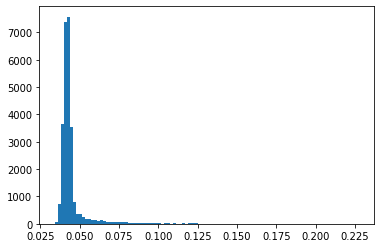

In [22]:
plt.hist(np.linalg.norm(item_embedding, axis=1),100);

In [23]:
from scipy.spatial.distance import cdist
def find_similar_movies(nn_movie_id, item_embedding, k=10, metric='cosine'):
    sim = -cdist(item_embedding, item_embedding[nn_movie_id].reshape(1, -1), metric=metric)
    #sim = np.matmul(item_embedding, item_embedding[nn_movie_id].transpose())
    return sim.squeeze().argsort()[-k:][::-1]

In [24]:
nn_to_movies = {}
movies_to_nn = {}
for _, row in items_mapping.iterrows():
    movies_to_nn[int(row['data'])] = int(row['id'])
    nn_to_movies[int(row['id'])] = int(row['data'])


In [26]:
import pandas as pd
movies = pd.read_csv("./data/ml-20m/movies.csv", index_col="movieId")

movie_ID = 1196 
print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

print("Similar movies: ")
similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

for i in similar_movies:
    if i==0:
        continue
    print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])

Query:  Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
Similar movies: 
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
356 Forrest Gump (1994) Comedy|Drama|Romance|War
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
110 Braveheart (1995) Action|Drama|War
318 Shawshank Redemption, The (1994) Crime|Drama
2028 Saving Private Ryan (1998) Action|Drama|War
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi


In [27]:
for movie_ID in range(1000):
    try:
        print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

        print("Similar movies: ")
        similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

        for i in similar_movies:
            if i==0:
                continue
            print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])
        print('===============\n')
    except Exception as e:
        print(e)
        pass

0
Query:  Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
Similar movies: 
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
457 Fugitive, The (1993) Thriller
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
356 Forrest Gump (1994) Comedy|Drama|Romance|War
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi

Query:  Jumanji (1995) Adventure|Children|Fantasy
Similar movies: 
2 Jumanji (1995) Adventure|Children|Fantasy
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
110 Braveheart (1995) Action|Drama|War
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
527 Schindler's List

27 Now and Then (1995) Children|Drama
1527 Fifth Element, The (1997) Action|Adventure|Comedy|Sci-Fi
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
3175 Galaxy Quest (1999) Adventure|Comedy|Sci-Fi
337 What's Eating Gilbert Grape (1993) Drama
1208 Apocalypse Now (1979) Action|Drama|War
316 Stargate (1994) Action|Adventure|Sci-Fi
1258 Shining, The (1980) Horror
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy

Query:  Persuasion (1995) Drama|Romance
Similar movies: 
28 Persuasion (1995) Drama|Romance
595 Beauty and the Beast (1991) Animation|Children|Fantasy|Musical|Romance|IMAX
16 Casino (1995) Crime|Drama
356 Forrest Gump (1994) Comedy|Drama|Romance|War
1097 E.T. the Extra-Terrestrial (1982) Children|Drama|Sci-Fi
318 Shawshank Redemption, The (1994) Crime|Drama
608 Fargo (1996) Comedy|Crime|Drama|Thriller
10 GoldenEye (1995) Action|Adventure|Thriller
1391 Mars Attacks! (1996) Action|Comedy|Sci-Fi
5952 Lord

41 Richard III (1995) Drama|War
95 Broken Arrow (1996) Action|Adventure|Thriller
527 Schindler's List (1993) Drama|War
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
1206 Clockwork Orange, A (1971) Crime|Drama|Sci-Fi|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
1200 Aliens (1986) Action|Adventure|Horror|Sci-Fi
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
592 Batman (1989) Action|Crime|Thriller

Query:  Dead Presidents (1995) Action|Crime|Drama
Similar movies: 
42 Dead Presidents (1995) Action|Crime|Drama
377 Speed (1994) Action|Romance|Thriller
4447 Legally Blonde (2001) Comedy|Romance
2150 Gods Must Be Crazy, The (1980) Adventure|Comedy
292 Outbreak (1995) Action|Drama|Sci-Fi|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
1625 Game, The (1997) Drama|Mystery|Thriller
367 Mask, The (1994) Action|Comedy|Crime|Fanta

55 Georgia (1995) Drama
3174 Man on the Moon (1999) Comedy|Drama
4007 Wall Street (1987) Drama
353 Crow, The (1994) Action|Crime|Fantasy|Thriller
1556 Speed 2: Cruise Control (1997) Action|Romance|Thriller
1377 Batman Returns (1992) Action|Crime
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
1250 Bridge on the River Kwai, The (1957) Adventure|Drama|War
36 Dead Man Walking (1995) Crime|Drama
1214 Alien (1979) Horror|Sci-Fi

Query:  Kids of the Round Table (1995) Adventure|Children|Fantasy
Similar movies: 
56 Kids of the Round Table (1995) Adventure|Children|Fantasy
103190 Oblivion Island: Haruka and the Magic Mirror (Hottarake no shima - Haruka to maho no kagami) (2009) Adventure|Animation|Fantasy
86894 Born to Be Bad (1950) Drama|Film-Noir
96909 Road North (Tie pohjoiseen) (2012) Comedy|Drama
87408 Täältä tullaan, elämä! (1980) Drama|Romance
84176 Waxworks (Das Wachsfigurenkabinett) (1924) Comedy|Drama|Romance|Thriller
103420 Life Without Dick (2002) Comedy|Crime|Romanc

69 Friday (1995) Comedy
1610 Hunt for Red October, The (1990) Action|Adventure|Thriller
1206 Clockwork Orange, A (1971) Crime|Drama|Sci-Fi|Thriller
377 Speed (1994) Action|Romance|Thriller
7438 Kill Bill: Vol. 2 (2004) Action|Drama|Thriller
2716 Ghostbusters (a.k.a. Ghost Busters) (1984) Action|Comedy|Sci-Fi
3114 Toy Story 2 (1999) Adventure|Animation|Children|Comedy|Fantasy
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
3481 High Fidelity (2000) Comedy|Drama|Romance
5618 Spirited Away (Sen to Chihiro no kamikakushi) (2001) Adventure|Animation|Fantasy

Query:  From Dusk Till Dawn (1996) Action|Comedy|Horror|Thriller
Similar movies: 
70 From Dusk Till Dawn (1996) Action|Comedy|Horror|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
858 Godfather, The (1972) Crime|Drama
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
318 Shawshank Rede

83 Once Upon a Time... When We Were Colored (1995) Drama|Romance
2083 Muppet Christmas Carol, The (1992) Children|Comedy|Musical
50068 Letters from Iwo Jima (2006) Drama|War
45431 Over the Hedge (2006) Adventure|Animation|Children|Comedy
1875 Clockwatchers (1997) Comedy
2720 Inspector Gadget (1999) Action|Adventure|Children|Comedy
8949 Sideways (2004) Comedy|Drama|Romance
902 Breakfast at Tiffany's (1961) Drama|Romance
46578 Little Miss Sunshine (2006) Adventure|Comedy|Drama
37733 History of Violence, A (2005) Action|Crime|Drama|Thriller

Query:  Last Summer in the Hamptons (1995) Comedy|Drama
Similar movies: 
84 Last Summer in the Hamptons (1995) Comedy|Drama
6538 Swimming Pool (2003) Drama|Mystery|Thriller
82931 Last Circus, The (Balada triste de trompeta) (Sad Trumpet Ballad, A) (2010) Comedy|Drama|War
6266 What a Girl Wants (2003) Comedy|Drama|Romance
3569 Idiots, The (Idioterne) (1998) Comedy|Drama
4812 SpaceCamp (1986) Adventure|Sci-Fi
4915 Beastmaster, The (1982) Action|Adventur

98 Shopping (1994) Action|Thriller
86487 Mildred Pierce (2011) Drama
71582 David and Lisa (1998) Drama
126407 Face of Terror (2005) Action|Drama|Thriller
5629 Jonah: A VeggieTales Movie (2002) Animation|Children|Musical
94433 Guilty Hands (1931) Crime|Drama
127066 Art and Craft (2014) Documentary
5869 True Confessions (1981) Crime|Drama
65235 Grocer's Son, The (Fils de l'épicier, Le) (2007) Drama|Romance
90268 Hell (2011) Horror|Sci-Fi|Thriller

Query:  Heidi Fleiss: Hollywood Madam (1995) Documentary
Similar movies: 
99 Heidi Fleiss: Hollywood Madam (1995) Documentary
3039 Trading Places (1983) Comedy
2100 Splash (1984) Comedy|Fantasy|Romance
48385 Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006) Comedy
353 Crow, The (1994) Action|Crime|Fantasy|Thriller
8798 Collateral (2004) Action|Crime|Drama|Thriller
1339 Dracula (Bram Stoker's Dracula) (1992) Fantasy|Horror|Romance|Thriller
912 Casablanca (1942) Drama|Romance
586 Home Alone (1990) Children

112 Rumble in the Bronx (Hont faan kui) (1995) Action|Adventure|Comedy|Crime
608 Fargo (1996) Comedy|Crime|Drama|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
590 Dances with Wolves (1990) Adventure|Drama|Western
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
356 Forrest Gump (1994) Comedy|Drama|Romance|War
4226 Memento (2000) Mystery|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance

Query:  Before and After (1996) Drama|Mystery
Similar movies: 
113 Before and After (1996) Drama|Mystery
5630 Red Dragon (2002) Crime|Mystery|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
539 Sleepless in Seattle (1993) Comedy|Drama|Romance
3897 Almost Famous (2000) Drama
2115 Indiana Jones and the Temple of Doom (1984) Action|Adventure|Fantasy
1291 Indiana Jones and the Last Crusade (1989) Action|Adventure
1416 Evit

126 NeverEnding Story III, The (1994) Adventure|Children|Fantasy
4571 Bill & Ted's Excellent Adventure (1989) Adventure|Comedy|Sci-Fi
357 Four Weddings and a Funeral (1994) Comedy|Romance
3897 Almost Famous (2000) Drama
48516 Departed, The (2006) Crime|Drama|Thriller
1246 Dead Poets Society (1989) Drama
454 Firm, The (1993) Drama|Thriller
1291 Indiana Jones and the Last Crusade (1989) Action|Adventure
1527 Fifth Element, The (1997) Action|Adventure|Comedy|Sci-Fi
1276 Cool Hand Luke (1967) Drama

Query:  Silences of the Palace, The (Saimt el Qusur) (1994) Drama
Similar movies: 
127 Silences of the Palace, The (Saimt el Qusur) (1994) Drama
5844 Prowler, The (a.k.a. Rosemary's Killer) (a.k.a. The Graduation) (1981) Horror
42559 Samurai Assassin (Samurai) (1965) Action|Adventure|Drama
103370 Hounds, The (2011) Crime|Horror|Thriller
106006 Breaking Point (1994) Thriller
126094 Claymation Comedy of Horrors (1991) Animation
129274 Police Python 357 (1976) Thriller
79458 Man Who Left His Will 

154 Beauty of the Day (Belle de jour) (1967) Drama
141 Birdcage, The (1996) Comedy
788 Nutty Professor, The (1996) Comedy|Fantasy|Romance|Sci-Fi
2791 Airplane! (1980) Comedy
1291 Indiana Jones and the Last Crusade (1989) Action|Adventure
592 Batman (1989) Action|Crime|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
173 Judge Dredd (1995) Action|Crime|Sci-Fi
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller

Query:  Beyond Rangoon (1995) Adventure|Drama|War
Similar movies: 
155 Beyond Rangoon (1995) Adventure|Drama|War
2410 Rocky III (1982) Action|Drama
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
68157 Inglourious Basterds (2009) Action|Drama|War
2003 Gremlins (1984) Comedy|Horror
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
587 Ghost (1990) Comedy|Drama|Fantasy|Romance|Thriller
5618 Spirited Away (Sen to Chihiro no kamikakushi) (2001) Adventure|Animation|Fantasy
1356 Star Trek: First Contact (1996) 

168 First Knight (1995) Action|Drama|Romance
500 Mrs. Doubtfire (1993) Comedy|Drama
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
153 Batman Forever (1995) Action|Adventure|Comedy|Crime
356 Forrest Gump (1994) Comedy|Drama|Romance|War
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
457 Fugitive, The (1993) Thriller
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller

Query:  Free Willy 2: The Adventure Home (1995) Adventure|Children|Drama
Similar movies: 
169 Free Willy 2: The Adventure Home (1995) Adventure|Children|Drama
590 Dances with Wolves (1990) Adventure|Drama|Western
36 Dead Man Walking (1995) Crime|Drama
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
4995 Beautiful Mind, A (2001) Drama|Romance
592 Batman (1989) Action|Crime|Thriller
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
5349 Spider-Man (2002) Action|Adventure|Sc

182 Moonlight and Valentino (1995) Drama|Romance
3983 You Can Count on Me (2000) Drama|Romance
3826 Hollow Man (2000) Horror|Sci-Fi|Thriller
428 Bronx Tale, A (1993) Drama
3697 Predator 2 (1990) Action|Sci-Fi|Thriller
531 Secret Garden, The (1993) Children|Drama
7147 Big Fish (2003) Drama|Fantasy|Romance
2297 What Dreams May Come (1998) Adventure|Drama|Fantasy|Romance
165 Die Hard: With a Vengeance (1995) Action|Crime|Thriller
2167 Blade (1998) Action|Horror|Thriller

Query:  Mute Witness (1994) Comedy|Horror|Thriller
Similar movies: 
183 Mute Witness (1994) Comedy|Horror|Thriller
2819 Three Days of the Condor (3 Days of the Condor) (1975) Drama|Mystery|Romance|Thriller
104841 Gravity (2013) Action|Sci-Fi|IMAX
1658 Life Less Ordinary, A (1997) Romance|Thriller
2011 Back to the Future Part II (1989) Adventure|Comedy|Sci-Fi
1281 Great Dictator, The (1940) Comedy|Drama|War
2297 What Dreams May Come (1998) Adventure|Drama|Fantasy|Romance
223 Clerks (1994) Comedy
194 Smoke (1995) Comedy|Dra

210 Wild Bill (1995) Western
1615 Edge, The (1997) Adventure|Drama
2828 Dudley Do-Right (1999) Children|Comedy
3006 Insider, The (1999) Drama|Thriller
662 Fear (1996) Thriller
1224 Henry V (1989) Action|Drama|Romance|War
3244 Goodbye Girl, The (1977) Comedy|Romance
3258 Death Becomes Her (1992) Comedy|Fantasy
31658 Howl's Moving Castle (Hauru no ugoku shiro) (2004) Adventure|Animation|Fantasy|Romance
8340 Escape from Alcatraz (1979) Drama|Thriller

Query:  Browning Version, The (1994) Drama
Similar movies: 
211 Browning Version, The (1994) Drama
342 Muriel's Wedding (1994) Comedy
168 First Knight (1995) Action|Drama|Romance
1918 Lethal Weapon 4 (1998) Action|Comedy|Crime|Thriller
1033 Fox and the Hound, The (1981) Animation|Children|Drama
783 Hunchback of Notre Dame, The (1996) Animation|Children|Drama|Musical|Romance
1359 Jingle All the Way (1996) Children|Comedy
1301 Forbidden Planet (1956) Drama|Sci-Fi
1022 Cinderella (1950) Animation|Children|Fantasy|Musical|Romance
2713 Lake Placi

225 Disclosure (1994) Drama|Thriller
2858 American Beauty (1999) Comedy|Drama
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
110 Braveheart (1995) Action|Drama|War
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama

Query:  Dream Man (1995) Thriller
Similar movies: 
226 Dream Man (1995) Thriller
26333 Terminal Man, The (1974) Sci-Fi|Thriller
7816 North Beach (2000) Comedy|Drama
108253 Shadow Puppets (2007) Horror|Mystery|Thriller
36276 Hidden (a.k.a. Cache) (Caché) (2005) Drama|Mystery|Thriller
81349 Provocateur (Prowokator) (1995) Drama
47644 Invincible (2006) Drama
98193 Invisible War, The (2012) Crime|Documentary|Drama|War
123981 The Admirable C

239 Goofy Movie, A (1995) Animation|Children|Comedy|Romance
2706 American Pie (1999) Comedy|Romance
919 Wizard of Oz, The (1939) Adventure|Children|Fantasy|Musical
1090 Platoon (1986) Drama|War
597 Pretty Woman (1990) Comedy|Romance
1240 Terminator, The (1984) Action|Sci-Fi|Thriller
541 Blade Runner (1982) Action|Sci-Fi|Thriller
357 Four Weddings and a Funeral (1994) Comedy|Romance
33493 Star Wars: Episode III - Revenge of the Sith (2005) Action|Adventure|Sci-Fi
1721 Titanic (1997) Drama|Romance

Query:  Hideaway (1995) Thriller
Similar movies: 
240 Hideaway (1995) Thriller
1590 Event Horizon (1997) Horror|Sci-Fi|Thriller
8798 Collateral (2004) Action|Crime|Drama|Thriller
2710 Blair Witch Project, The (1999) Drama|Horror|Thriller
551 Nightmare Before Christmas, The (1993) Animation|Children|Fantasy|Musical
1203 12 Angry Men (1957) Drama
3359 Breaking Away (1979) Comedy|Drama
4901 Spy Game (2001) Action|Crime|Drama|Thriller
3981 Red Planet (2000) Action|Sci-Fi|Thriller
3527 Predator (19

267 Major Payne (1995) Comedy
1653 Gattaca (1997) Drama|Sci-Fi|Thriller
1721 Titanic (1997) Drama|Romance
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
1961 Rain Man (1988) Drama
2115 Indiana Jones and the Temple of Doom (1984) Action|Adventure|Fantasy
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
1258 Shining, The (1980) Horror

Query:  Little Odessa (1994) Crime|Drama
Similar movies: 
268 Little Odessa (1994) Crime|Drama
33679 Mr. & Mrs. Smith (2005) Action|Adventure|Comedy|Romance
1234 Sting, The (1973) Comedy|Crime
1408 Last of the Mohicans, The (1992) Action|Romance|War|Western
724 Craft, The (1996) Drama|Fantasy|Horror|Thriller
70 From Dusk Till Dawn (1996) Action|Comedy|Horror|Thriller
6934 Matrix Revolutions, The (2003) Action|Adventure|Sci-Fi|Thriller|IMAX
1777 Wedding Singer, The (1998) Comedy|Romance
16 Casino (1995) Crime|Drama
1961 Rain Man (198

281 Nobody's Fool (1994) Comedy|Drama|Romance
8636 Spider-Man 2 (2004) Action|Adventure|Sci-Fi|IMAX
318 Shawshank Redemption, The (1994) Crime|Drama
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
1214 Alien (1979) Horror|Sci-Fi
1213 Goodfellas (1990) Crime|Drama
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
2858 American Beauty (1999) Comedy|Drama
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
2355 Bug's Life, A (1998) Adventure|Animation|Children|Comedy

Query:  Nell (1994) Drama
Similar movies: 
282 Nell (1994) Drama
318 Shawshank Redemption, The (1994) Crime|Drama
527 Schindler's List (1993) Drama|War
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
541 Blade Runner (1982) Action|Sci-Fi|Thriller
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller

309 Red Firecracker, Green Firecracker (Pao Da Shuang Deng) (1994) Drama
5152 We Were Soldiers (2002) Action|Drama|War
55442 Persepolis (2007) Animation|Drama
7445 Man on Fire (2004) Action|Crime|Drama|Mystery|Thriller
920 Gone with the Wind (1939) Drama|Romance|War
953 It's a Wonderful Life (1946) Drama|Fantasy|Romance
6796 Boyz N the Hood (1991) Crime|Drama
381 When a Man Loves a Woman (1994) Drama|Romance
1682 Truman Show, The (1998) Comedy|Drama|Sci-Fi
5459 Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002) Action|Comedy|Sci-Fi

Query:  Rent-a-Kid (1995) Comedy
Similar movies: 
310 Rent-a-Kid (1995) Comedy
1066 Shall We Dance (1937) Comedy|Musical|Romance
2472 Tough Guys (1986) Comedy
6294 Bulletproof Monk (2003) Action|Adventure|Sci-Fi
62376 City of Ember (2008) Adventure|Children|Sci-Fi
6659 Tremors (1990) Comedy|Horror|Sci-Fi
7173 Along Came Polly (2004) Comedy|Romance
32598 Fever Pitch (2005) Comedy|Romance
44828 Slither (2006) Comedy|Horror|Sci-Fi
3028 Taming of the Shrew, Th

324 Sum of Us, The (1994) Comedy|Drama
2920 Children of Paradise (Les enfants du paradis) (1945) Drama|Romance
61024 Pineapple Express (2008) Action|Comedy|Crime
1212 Third Man, The (1949) Film-Noir|Mystery|Thriller
89745 Avengers, The (2012) Action|Adventure|Sci-Fi|IMAX
3101 Fatal Attraction (1987) Drama|Thriller
5463 Reign of Fire (2002) Action|Adventure|Fantasy
3578 Gladiator (2000) Action|Adventure|Drama
12 Dracula: Dead and Loving It (1995) Comedy|Horror
222 Circle of Friends (1995) Drama|Romance

Query:  National Lampoon's Senior Trip (1995) Comedy
Similar movies: 
325 National Lampoon's Senior Trip (1995) Comedy
880 Island of Dr. Moreau, The (1996) Sci-Fi|Thriller
339 While You Were Sleeping (1995) Comedy|Romance
24 Powder (1995) Drama|Sci-Fi
6373 Bruce Almighty (2003) Comedy|Drama|Fantasy|Romance
2572 10 Things I Hate About You (1999) Comedy|Romance
300 Quiz Show (1994) Drama
2366 King Kong (1933) Action|Adventure|Fantasy|Horror
2391 Simple Plan, A (1998) Crime|Drama|Thriller
2

338 Virtuosity (1995) Action|Sci-Fi|Thriller
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
924 2001: A Space Odyssey (1968) Adventure|Drama|Sci-Fi
380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller
110 Braveheart (1995) Action|Drama|War
434 Cliffhanger (1993) Action|Adventure|Thriller
34 Babe (1995) Children|Drama
253 Interview with the Vampire: The Vampire Chronicles (1994) Drama|Horror
1101 Top Gun (1986) Action|Romance
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller

Query:  While You Were Sleeping (1995) Comedy|Romance
Similar movies: 
339 While You Were Sleeping (1995) Comedy|Romance
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
589 Terminator 2: Judgment Day

352 Crooklyn (1994) Comedy|Drama
2243 Broadcast News (1987) Comedy|Drama|Romance
58559 Dark Knight, The (2008) Action|Crime|Drama|IMAX
2770 Bowfinger (1999) Comedy
2116 Lord of the Rings, The (1978) Adventure|Animation|Children|Fantasy
1729 Jackie Brown (1997) Crime|Drama|Thriller
3000 Princess Mononoke (Mononoke-hime) (1997) Action|Adventure|Animation|Drama|Fantasy
743 Spy Hard (1996) Comedy
1027 Robin Hood: Prince of Thieves (1991) Adventure|Drama
1704 Good Will Hunting (1997) Drama|Romance

Query:  Crow, The (1994) Action|Crime|Fantasy|Thriller
Similar movies: 
353 Crow, The (1994) Action|Crime|Fantasy|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
110 Braveheart (1995) Action|Drama|War
457 Fugitive, The (1993) Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
592 Batman (1989) Action|Crime|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
165 Die Hard: With a Vengeance (1995) Action|Crime|Thriller
2571 Matrix, The (1999) Action|Sci-F

366 Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994) Drama|Horror|Mystery|Thriller
2502 Office Space (1999) Comedy|Crime
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
2858 American Beauty (1999) Comedy|Drama
1610 Hunt for Red October, The (1990) Action|Adventure|Thriller
5060 M*A*S*H (a.k.a. MASH) (1970) Comedy|Drama|War
350 Client, The (1994) Drama|Mystery|Thriller
2001 Lethal Weapon 2 (1989) Action|Comedy|Crime|Drama
733 Rock, The (1996) Action|Adventure|Thriller
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX

Query:  Mask, The (1994) Action|Comedy|Crime|Fantasy
Similar movies: 
367 Mask, The (1994) Action|Comedy|Crime|Fantasy
356 Forrest Gump (1994) Comedy|Drama|Romance|War
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
780 Independence Day (a.k.a

380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
110 Braveheart (1995) Action|Drama|War
318 Shawshank Redemption, The (1994) Crime|Drama
377 Speed (1994) Action|Romance|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
592 Batman (1989) Action|Crime|Thriller

Query:  When a Man Loves a Woman (1994) Drama|Romance
Similar movies: 
381 When a Man Loves a Woman (1994) Drama|Romance
592 Batman (1989) Action|Crime|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
590 Dances with Wolves (1990) Adventure|Drama|Western
33794 Batman Begins (2005) Action|Crime|IMAX
3081 Sleepy Hollow (1999) Fantasy|Horror|Mystery|Romance
356 Forrest Gump (1994) Comedy|Drama|

408 8 Seconds (1994) Drama
1841 Gingerbread Man, The (1998) Drama|Thriller
81 Things to Do in Denver When You're Dead (1995) Crime|Drama|Romance
7323 Good bye, Lenin! (2003) Comedy|Drama
1203 12 Angry Men (1957) Drama
31 Dangerous Minds (1995) Drama
2871 Deliverance (1972) Adventure|Drama|Thriller
2141 American Tail, An (1986) Adventure|Animation|Children|Comedy
4963 Ocean's Eleven (2001) Crime|Thriller
1676 Starship Troopers (1997) Action|Sci-Fi

Query:  Above the Rim (1994) Crime|Drama
Similar movies: 
409 Above the Rim (1994) Crime|Drama
2014 Freaky Friday (1977) Children|Comedy|Fantasy
3160 Magnolia (1999) Drama
2117 1984 (Nineteen Eighty-Four) (1984) Drama|Sci-Fi
3093 McCabe & Mrs. Miller (1971) Drama|Western
1359 Jingle All the Way (1996) Children|Comedy
502 Next Karate Kid, The (1994) Action|Children|Romance
7701 Look Who's Talking Too (1990) Comedy|Romance
1888 Hope Floats (1998) Comedy|Drama|Romance
2125 Ever After: A Cinderella Story (1998) Comedy|Drama|Romance

Query:  Addam

422 Blink (1994) Thriller
529 Searching for Bobby Fischer (1993) Drama
317 Santa Clause, The (1994) Comedy|Drama|Fantasy
3160 Magnolia (1999) Drama
608 Fargo (1996) Comedy|Crime|Drama|Thriller
6874 Kill Bill: Vol. 1 (2003) Action|Crime|Thriller
736 Twister (1996) Action|Adventure|Romance|Thriller
1610 Hunt for Red October, The (1990) Action|Adventure|Thriller
111 Taxi Driver (1976) Crime|Drama|Thriller
5816 Harry Potter and the Chamber of Secrets (2002) Adventure|Fantasy

Query:  Blown Away (1994) Action|Thriller
Similar movies: 
423 Blown Away (1994) Action|Thriller
457 Fugitive, The (1993) Thriller
736 Twister (1996) Action|Adventure|Romance|Thriller
21 Get Shorty (1995) Comedy|Crime|Thriller
111 Taxi Driver (1976) Crime|Drama|Thriller
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
1188 Strictly Ballroom (1992) Comedy|Romance
2947 Goldfinger (1964) Action|Adventure|Thriller
924 2001: A Space Odyssey (1968) Adventure|Drama|Sci-Fi
588 Aladdin (1992) 

450 With Honors (1994) Comedy|Drama
3147 Green Mile, The (1999) Crime|Drama
4226 Memento (2000) Mystery|Thriller
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
527 Schindler's List (1993) Drama|War
1127 Abyss, The (1989) Action|Adventure|Sci-Fi|Thriller
2997 Being John Malkovich (1999) Comedy|Drama|Fantasy
410 Addams Family Values (1993) Children|Comedy|Fantasy

Query:  Flesh and Bone (1993) Drama|Mystery|Romance
Similar movies: 
451 Flesh and Bone (1993) Drama|Mystery|Romance
637 Sgt. Bilko (1996) Comedy
4979 Royal Tenenbaums, The (2001) Comedy|Drama
72 Kicking and Screaming (1995) Comedy|Drama
2321 Pleasantville (1998) Comedy|Drama|Fantasy
1203 12 Angry Men (1957) Drama
2541 Cruel Intentions (1999) Drama
314 Secret of Roan Inish, The (1994) Children|Drama|Fantasy|Mystery
4148 Hannibal (2001) Horror|Thriller
3745 Titan A.E. (2

475 In the Name of the Father (1993) Drama
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
153 Batman Forever (1995) Action|Adventure|Comedy|Crime
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
6377 Finding Nemo (2003) Adventure|Animation|Children|Comedy
288 Natural Born Killers (1994) Action|Crime|Thriller

Query:  Inkwell, The (1994) Comedy|Drama
Similar movies: 
476 Inkwell, The (1994) Comedy|Drama
6703 Order, The (2003) Horror|Mystery|Thriller
1539 Twin Town (1997) Comedy|Crime
6552 Dirty Pretty Things (2002) Crime|Drama|Thriller
3261 Singles (1992) Comedy|Drama|Romance
47044 Miami Vice (2006) Action|Crime|Drama|Thriller
3494 True Grit (1969) Adventure|Drama|Western
4280 World According to Garp, The (1982) Comedy|Drama|R

500 Mrs. Doubtfire (1993) Comedy|Drama
457 Fugitive, The (1993) Thriller
2028 Saving Private Ryan (1998) Action|Drama|War
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
2858 American Beauty (1999) Comedy|Drama
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller

Query:  Naked (1993) Drama
Similar movies: 
501 Naked (1993) Drama
1961 Rain Man (1988) Drama
1221 Godfather: Part II, The (1974) Crime|Drama
1259 Stand by Me (1986) Adventure|Drama
2028 Saving Private Ryan (1998) Action|Drama|War
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
1704 Good Will Hunting (1997) Drama|Romance
350 Client, The (1994) Drama|Mystery|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1527 Fifth Element, The (1997) Action|Adventure|Comedy|Sci-Fi

Quer

528 Scout, The (1994) Comedy|Drama
2202 Lifeboat (1944) Drama|War
3155 Anna and the King (1999) Drama|Romance
2746 Little Shop of Horrors (1986) Comedy|Horror|Musical
1616 Peacemaker, The (1997) Action|Thriller|War
6870 Mystic River (2003) Crime|Drama|Mystery
1968 Breakfast Club, The (1985) Comedy|Drama
44555 Lives of Others, The (Das leben der Anderen) (2006) Drama|Romance|Thriller
1994 Poltergeist (1982) Horror|Thriller
750 Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) Comedy|War

Query:  Searching for Bobby Fischer (1993) Drama
Similar movies: 
529 Searching for Bobby Fischer (1993) Drama
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
608 Fargo (1996) Comedy|Crime|Drama|Thriller
454 Firm, The (1993) Drama|Thriller
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thrille

457 Fugitive, The (1993) Thriller
592 Batman (1989) Action|Crime|Thriller
590 Dances with Wolves (1990) Adventure|Drama|Western
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
527 Schindler's List (1993) Drama|War
356 Forrest Gump (1994) Comedy|Drama|Romance|War
586 Home Alone (1990) Children|Comedy
380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller

Query:  Trial by Jury (1994) Crime|Drama|Thriller
Similar movies: 
554 Trial by Jury (1994) Crime|Drama|Thriller
933 To Catch a Thief (1955) Crime|Mystery|Romance|Thriller
2114 Outsiders, The (1983) Drama
73266 Youth in Revolt (2009) Comedy|Drama|Romance
1719 Sweet Hereafter, The (1997) Drama
2108 L.A. Story (1991) Comedy|Romance
533 Shadow, The (1994) Action|Adventure|Fantasy|Mystery
3185 Snow Falling on Cedars (1999) Drama
40732 Descent, The (2005) Adventure|Drama|Horror|Thriller
2560 Ravenous (1999) Horror|Thriller

Query:  True Romance (1993) Crime|Thriller
Similar movies: 
555 True Romance (1993) Cri

579 Escort, The (Scorta, La) (1993) Crime|Thriller
8404 Hound of the Baskervilles, The (1939) Crime|Mystery|Thriller
45346 Lollilove (2004) Comedy
2238 Seven Beauties (Pasqualino Settebellezze) (1976) Comedy|Drama
59988 Boys and Girls Guide to Getting Down, The (2006) Comedy
8787 Thunderbirds Are GO (1966) Action|Sci-Fi
90405 In Time (2011) Crime|Sci-Fi|Thriller
121161 Tactical Force (2011) Action|Comedy|Crime|Thriller
4482 Bright Lights, Big City (1988) Drama
90064 That Day (Ce jour-là) (2003) Comedy|Crime|Drama|Mystery

Query:  Princess Caraboo (1994) Drama
Similar movies: 
580 Princess Caraboo (1994) Drama
5064 The Count of Monte Cristo (2002) Action|Adventure|Drama|Romance|Thriller
55052 Atonement (2007) Drama|Romance|War
2279 Urban Legend (1998) Horror|Thriller
4974 Not Another Teen Movie (2001) Comedy
2412 Rocky V (1990) Action|Drama
745 Wallace & Gromit: A Close Shave (1995) Animation|Children|Comedy
3384 Taking of Pelham One Two Three, The (1974) Action|Crime
4034 Traffic (2000

593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
2858 American Beauty (1999) Comedy|Drama
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
527 Schindler's List (1993) Drama|War
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
110 Braveheart (1995) Action|Drama|War
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi

Query:  Snow White and the Seven Dwarfs (1937) Animation|Children|Drama|Fantasy|Musical
Similar movies: 
594 Snow White and the Seven Dwarfs (1937) Animation|Children|Drama|Fantasy|Musical
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
858 Godfather, The (1972) Crime|Drama
356 Forrest Gump (1994) Comedy|Drama|Romance|War
527 Schindler's List (1993) Drama|War
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
2571 Mat

607 Century (1993) Drama
114035 Calling, The (2014) Thriller
98847 Enforcer, The (Gei ba ba de xin) (1995) Action
112999 Fugitives (Fugitivas) (2000) Drama|Thriller
97984 Wake in Fright (1971) Drama|Thriller
118177 Baffled! (1973) Mystery|Sci-Fi|Thriller
51817 Diary of a Hitman (1991) Crime|Drama|Thriller
125213 Red Heat (1985) Thriller
110551 Boca (2010) Action|Crime|Drama
115955 Category 7: The End of the World (2005) Action|Drama|Thriller

Query:  Fargo (1996) Comedy|Crime|Drama|Thriller
Similar movies: 
608 Fargo (1996) Comedy|Crime|Drama|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War
527 Schindler's List (1993) Drama|War
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
260 Star Wars: Episode IV - A New Hop

634 Theodore Rex (1995) Comedy
81591 Black Swan (2010) Drama|Thriller
611 Hellraiser: Bloodline (1996) Action|Horror|Sci-Fi
5288 Atomic Cafe, The (1982) Documentary|War
2769 Yards, The (2000) Crime|Drama
1892 Perfect Murder, A (1998) Thriller
2770 Bowfinger (1999) Comedy
106489 Hobbit: The Desolation of Smaug, The (2013) Adventure|Fantasy|IMAX
64034 Boy in the Striped Pajamas, The (Boy in the Striped Pyjamas, The) (2008) Drama|War
959 Of Human Bondage (1934) Drama

Query:  Family Thing, A (1996) Comedy|Drama
Similar movies: 
635 Family Thing, A (1996) Comedy|Drama
36 Dead Man Walking (1995) Crime|Drama
1206 Clockwork Orange, A (1971) Crime|Drama|Sci-Fi|Thriller
2987 Who Framed Roger Rabbit? (1988) Adventure|Animation|Children|Comedy|Crime|Fantasy|Mystery
5459 Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002) Action|Comedy|Sci-Fi
216 Billy Madison (1995) Comedy
8636 Spider-Man 2 (2004) Action|Adventure|Sci-Fi|IMAX
4447 Legally Blonde (2001) Comedy|Romance
4878 Donnie Darko (2001) Dram

661 James and the Giant Peach (1996) Adventure|Animation|Children|Fantasy|Musical
1580 Men in Black (a.k.a. MIB) (1997) Action|Comedy|Sci-Fi
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
527 Schindler's List (1993) Drama|War
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War
1265 Groundhog Day (1993) Comedy|Fantasy|Romance
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
608 Fargo (1996) Comedy|Crime|Drama|Thriller
2762 Sixth Sense, The (1999) Drama|Horror|Mystery

Query:  Fear (1996) Thriller
Similar movies: 
662 Fear (1996) Thriller
2324 Life Is Beautiful (La Vita è bella) (1997) Comedy|Drama|Romance|War
1036 Die Hard (1988) Action|Crime|Thriller
923 Citizen Kane (1941) Drama|Mystery
316 Stargate (1994) Action|Adventure|Sci-Fi
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
34 Babe (1995) Children|

676 They Bite (1996) Comedy|Horror|Sci-Fi
103288 Revisionaries, The (2012) Documentary
3817 Other Side of Sunday, The (Søndagsengler) (1996) Comedy|Drama
84525 Virus X (2010) Horror|Sci-Fi
5849 I'm Starting From Three (Ricomincio da Tre) (1981) Comedy
77359 Red Riding: 1983 (2009) Crime|Drama|Mystery
84799 Asphyx, The (1973) Horror|Sci-Fi
8572 Littlest Rebel, The (1935) Children|Drama
33994 Silent Witness (Do Not Disturb) (1999) Action|Comedy|Thriller
3166 Brenda Starr (1989) Adventure

677
Query:  Some Folks Call It a Sling Blade (1993) Drama|Thriller
Similar movies: 
678 Some Folks Call It a Sling Blade (1993) Drama|Thriller
6365 Matrix Reloaded, The (2003) Action|Adventure|Sci-Fi|Thriller|IMAX
786 Eraser (1996) Action|Drama|Thriller
539 Sleepless in Seattle (1993) Comedy|Drama|Romance
3499 Misery (1990) Drama|Horror|Thriller
919 Wizard of Oz, The (1939) Adventure|Children|Fantasy|Musical
318 Shawshank Redemption, The (1994) Crime|Drama
1291 Indiana Jones and the Last Crusade (1989) 

1035 Sound of Music, The (1965) Musical|Romance
1429 First Strike (Police Story 4: First Strike) (Ging chaat goo si 4: Ji gaan daan yam mo) (1996) Action|Adventure|Comedy|Thriller
54503 Superbad (2007) Comedy
26662 Kiki's Delivery Service (Majo no takkyûbin) (1989) Adventure|Animation|Children|Drama|Fantasy

Query:  Sunset Park (1996) Drama
Similar movies: 
706 Sunset Park (1996) Drama
5106 Crossroads (2002) Comedy|Musical|Romance
2915 Risky Business (1983) Comedy
258 Kid in King Arthur's Court, A (1995) Adventure|Children|Comedy|Fantasy|Romance
48877 Saw III (2006) Crime|Horror|Thriller
58154 Other Boleyn Girl, The (2008) Drama|Romance
8183 Educating Rita (1983) Comedy|Drama
92 Mary Reilly (1996) Drama|Horror|Thriller
1515 Volcano (1997) Action|Drama|Thriller
5791 Frida (2002) Drama|Romance

Query:  Mulholland Falls (1996) Crime|Drama|Thriller
Similar movies: 
707 Mulholland Falls (1996) Crime|Drama|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War
318 Shawshank Redemption, Th

719 Multiplicity (1996) Comedy
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
253 Interview with the Vampire: The Vampire Chronicles (1994) Drama|Horror
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
1221 Godfather: Part II, The (1974) Crime|Drama
2858 American Beauty (1999) Comedy|Drama
1079 Fish Called Wanda, A (1988) Comedy|Crime
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
1682 Truman Show, The (1998) Comedy|Drama|Sci-Fi

Query:  Wallace & Gromit: The Best of Aardman Animation (1996) Adventure|Animation|Comedy
Similar movies: 
720 Wallace & Gromit: The Best of Aardman Animation (1996) Adventure|Animation|Comedy
380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
110 Braveheart (1995) Action|Drama|War
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
4306 Shrek (2001) Adventure|Animation|Children|Comedy|Fantasy|Romance
21 G

733 Rock, The (1996) Action|Adventure|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
318 Shawshank Redemption, The (1994) Crime|Drama
858 Godfather, The (1972) Crime|Drama
2028 Saving Private Ryan (1998) Action|Drama|War
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
527 Schindler's List (1993) Drama|War
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
590 Dances with Wolves (1990) Adventure|Drama|Western

Query:  Getting Away With Murder (1996) Comedy
Similar movies: 
734 Getting Away With Murder (1996) Comedy
51638 Westerner, The (1940) Western
45503 Peaceful Warrior (2006) Drama
99448 Trek Nation (2010) Documentary
115160 Two Weeks in Another Town (1962) Drama
123159 Hercules and the Lost Kingdom (1994) Action|Adventure|Fantasy|Sci-Fi
8953 Stella Street (2004) Comedy
50354 Return of Don Camillo, The (Retour de Don Camillo, Le) (1956) Comedy
92335 Big 

748 Arrival, The (1996) Action|Sci-Fi|Thriller
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
318 Shawshank Redemption, The (1994) Crime|Drama
342 Muriel's Wedding (1994) Comedy
231 Dumb & Dumber (Dumb and Dumber) (1994) Adventure|Comedy
150 Apollo 13 (1995) Adventure|Drama|IMAX
434 Cliffhanger (1993) Action|Adventure|Thriller
608 Fargo (1996) Comedy|Crime|Drama|Thriller
356 Forrest Gump (1994) Comedy|Drama|Romance|War

Query:  Man from Down Under, The (1943) Drama
Similar movies: 
749 Man from Down Under, The (1943) Drama
61301 American Zombie (2007) Comedy|Horror
7900 Frankenstein Must Be Destroyed (1969) Drama|Horror|Sci-Fi
117513 Jamilya (1969) Drama|Romance|War
74266 I Never Sang for My Father (1970) Drama
80290 It's a Great Feeling (1949) Comedy
105155 America the Beautiful (2007)  Documentary
101335 Stolen Seas (2012) Adventure|Crime|Documentary
104817 Badman's Co

774 Wend Kuuni (a.k.a. God's Gift) (1982) Drama
55757 Chilly Scenes of Winter (Head Over Heels) (1979) Comedy|Drama|Romance
51082 Tyler Perry's Daddy's Little Girls (2007) Comedy|Romance
8632 Secret Society (2002) Comedy
107561 Someone Like Him (Einer wie Bruno) (2011) Comedy|Drama
46325 Susan Lenox (Her Fall and Rise) (1931) Adventure|Drama|Romance
27321 For Love or Country: The Arturo Sandoval Story (2000) Drama|Musical
67878 Lonely Man, The (1957) Western
72637 Printed Rainbow (2006) Adventure|Animation|Fantasy
26672 Speaking Parts (1989) Drama

Query:  Spirits of the Dead (1968) Horror|Mystery
Similar movies: 
775 Spirits of the Dead (1968) Horror|Mystery
33312 Cocoanuts, The (1929) Comedy|Musical
2131 Autumn Sonata (Höstsonaten) (1978) Drama
44245 Leprechaun in the Hood (2000) Action|Comedy|Horror
33421 Dear Wendy (2005) Drama
4622 Loverboy (1989) Comedy
36509 Cave, The (2005) Action|Adventure|Horror|Mystery|Sci-Fi|Thriller
109673 300: Rise of an Empire (2014) Action|Drama|War|IMA

799 Frighteners, The (1996) Comedy|Horror|Thriller
608 Fargo (1996) Comedy|Crime|Drama|Thriller
592 Batman (1989) Action|Crime|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
293 Léon: The Professional (a.k.a. The Professional) (Léon) (1994) Action|Crime|Drama|Thriller
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
858 Godfather, The (1972) Crime|Drama
1222 Full Metal Jacket (1987) Drama|War
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller

Query:  Lone Star (1996) Drama|Mystery|Western
Similar movies: 
800 Lone Star (1996) Drama|Mystery|Western
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
165 Die Hard: With a Vengeance (1995) Action|Crime|Thriller
4027 O Brother, Where Art Thou? (2000) Adventure|Comedy|Crime
593 Silence of the Lambs, The (1991) Crime|Horror|Thriller
377 Speed (1994) Action|Romance|Thriller
10

828 Adventures of Pinocchio, The (1996) Adventure|Children
2054 Honey, I Shrunk the Kids (1989) Adventure|Children|Comedy|Fantasy|Sci-Fi
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
4027 O Brother, Where Art Thou? (2000) Adventure|Comedy|Crime
368 Maverick (1994) Adventure|Comedy|Western
3996 Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000) Action|Drama|Romance
1784 As Good as It Gets (1997) Comedy|Drama|Romance
223 Clerks (1994) Comedy
1136 Monty Python and the Holy Grail (1975) Adventure|Comedy|Fantasy
357 Four Weddings and a Funeral (1994) Comedy|Romance

Query:  Joe's Apartment (1996) Comedy|Fantasy|Musical
Similar movies: 
829 Joe's Apartment (1996) Comedy|Fantasy|Musical
80463 Social Network, The (2010) Drama
2712 Eyes Wide Shut (1999) Drama|Mystery|Thriller
1208 Apocalypse Now (1979) Action|Drama|War
2396 Shakespeare in Love (1998) Comedy|Drama|Romance
2291 Edward Scissorhands (1990) Drama|Fantasy|Romance
1639 Chasing Amy (1997) Comedy|

842 Tales from the Crypt Presents: Bordello of Blood (1996) Comedy|Horror
1206 Clockwork Orange, A (1971) Crime|Drama|Sci-Fi|Thriller
2997 Being John Malkovich (1999) Comedy|Drama|Fantasy
380 True Lies (1994) Action|Adventure|Comedy|Romance|Thriller
2002 Lethal Weapon 3 (1992) Action|Comedy|Crime|Drama
2916 Total Recall (1990) Action|Adventure|Sci-Fi|Thriller
4878 Donnie Darko (2001) Drama|Mystery|Sci-Fi|Thriller
1214 Alien (1979) Horror|Sci-Fi
1544 Lost World: Jurassic Park, The (1997) Action|Adventure|Sci-Fi|Thriller
4447 Legally Blonde (2001) Comedy|Romance

Query:  Lotto Land (1995) Drama
Similar movies: 
843 Lotto Land (1995) Drama
73511 Horsemen (2009) Crime|Drama|Horror|Mystery|Thriller
90071 Music Never Stopped, The (2011) Drama
5321 Triumph of Love, The (2001) Comedy
128362 Burn Paris Burn (2009) Animation|Fantasy|Mystery
72090 13th Letter, The (1951) Film-Noir
50583 Linda Linda Linda (2005) Comedy|Drama
117326 Take the Trash (2008) Comedy
128401 Hunted City (1979) (no genres 

870 Gone Fishin' (1997) Comedy
3341 Born Yesterday (1950) Comedy
2443 Playing by Heart (1998) Drama|Romance
89745 Avengers, The (2012) Action|Adventure|Sci-Fi|IMAX
5254 Blade II (2002) Action|Horror|Thriller
3148 Cider House Rules, The (1999) Drama
2088 Popeye (1980) Adventure|Comedy|Musical
2087 Peter Pan (1953) Animation|Children|Fantasy|Musical
261 Little Women (1994) Drama
305 Ready to Wear (Pret-A-Porter) (1994) Comedy

Query:  Lover's Knot (1996) Comedy
Similar movies: 
871 Lover's Knot (1996) Comedy
60110 Tom Sawyer (1973) Adventure|Children|Musical
26079 David and Lisa (1962) Drama
68976 Two English Girls (Les deux anglaises et le continent) (1971) Drama|Romance
74706 Commune, La (Paris, 1871) (2000) Drama|War
102991 Berberian Sound Studio (2012) Drama|Horror|Thriller
84829 Three Crowns of the Sailor (Les trois couronnes du matelot) (1983) Drama|Fantasy
93330 Cure, The (1917) Comedy
25929 Nightmare Alley (1947) Drama|Film-Noir
35640 Last of Mrs. Cheyney, The (1937) Comedy|Drama

897 For Whom the Bell Tolls (1943) Adventure|Drama|Romance|War
2329 American History X (1998) Crime|Drama
3409 Final Destination (2000) Drama|Thriller
235 Ed Wood (1994) Comedy|Drama
17 Sense and Sensibility (1995) Drama|Romance
1673 Boogie Nights (1997) Drama
1254 Treasure of the Sierra Madre, The (1948) Action|Adventure|Drama|Western
3996 Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000) Action|Drama|Romance
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
1042 That Thing You Do! (1996) Comedy|Drama

Query:  Philadelphia Story, The (1940) Comedy|Drama|Romance
Similar movies: 
898 Philadelphia Story, The (1940) Comedy|Drama|Romance
110 Braveheart (1995) Action|Drama|War
1721 Titanic (1997) Drama|Romance
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
648 Mission: Impossible (1996) Action|Adventure|Mystery|Thriller
318 Shawshank Redemption, The (1994) Crime|Drama
1206 Clockwork Orange, A (1971) Crime|Drama|Sci-Fi|Thriller
356 Forrest Gump (1994) Co

910 Some Like It Hot (1959) Comedy|Crime
608 Fargo (1996) Comedy|Crime|Drama|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
527 Schindler's List (1993) Drama|War
1617 L.A. Confidential (1997) Crime|Film-Noir|Mystery|Thriller
2571 Matrix, The (1999) Action|Sci-Fi|Thriller
858 Godfather, The (1972) Crime|Drama
1291 Indiana Jones and the Last Crusade (1989) Action|Adventure

Query:  Charade (1963) Comedy|Crime|Mystery|Romance|Thriller
Similar movies: 
911 Charade (1963) Comedy|Crime|Mystery|Romance|Thriller
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
1230 Annie Hall (1977) Comedy|Romance
508 Philadelphia (1993) Drama
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
2858 American Beauty (1999) Comedy|Drama
1265 Groundhog Day (1993) Comedy|Fantasy|Romance
457 Fugitive, The (1993) Thriller
47 

924 2001: A Space Odyssey (1968) Adventure|Drama|Sci-Fi
356 Forrest Gump (1994) Comedy|Drama|Romance|War
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
110 Braveheart (1995) Action|Drama|War

Query:  Golden Earrings (1947) Adventure|Romance|War
Similar movies: 
925 Golden Earrings (1947) Adventure|Romance|War
8603 Coming Out (1989) Drama
55782 Citizen Dog (Mah nakorn) (2004) Comedy|Fantasy|Romance
58898 Aerial, The (La antena) (2007) Adventure|Fantasy|Film-Noir|Mystery|Sci-Fi
5567 Incubus, The (1981) Horror|Thriller
4860 Making the Grade (1984) Comedy
7990 Rock 'N' Roll High School (1979) C

951 His Girl Friday (1940) Comedy|Romance
6377 Finding Nemo (2003) Adventure|Animation|Children|Comedy
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
7361 Eternal Sunshine of the Spotless Mind (2004) Drama|Romance|Sci-Fi
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
527 Schindler's List (1993) Drama|War
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance

Query:  Around the World in 80 Days (1956) Adventure|Comedy
Similar movies: 
952 Around the World in 80 Days (1956) Adventure|Comedy
344 Ace Ventura: Pet Detective (1994) Comedy
2268 Few Good Men, A (1992) Crime|Drama|Thriller
5418 Bourne Identity, The (2002) Action|Mystery|Thriller
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
733 Rock, The (1996) Action|Adventure|Thriller
1278 Young Frankenstein (1974) Comedy|Fantasy
165 Die Hard: With a Veng

965 39 Steps, The (1935) Drama|Mystery|Thriller
39 Clueless (1995) Comedy|Romance
608 Fargo (1996) Comedy|Crime|Drama|Thriller
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
1653 Gattaca (1997) Drama|Sci-Fi|Thriller
1407 Scream (1996) Comedy|Horror|Mystery|Thriller
8961 Incredibles, The (2004) Action|Adventure|Animation|Children|Comedy
356 Forrest Gump (1994) Comedy|Drama|Romance|War
2762 Sixth Sense, The (1999) Drama|Horror|Mystery
480 Jurassic Park (1993) Action|Adventure|Sci-Fi|Thriller

Query:  Walk in the Sun, A (1945) War
Similar movies: 
966 Walk in the Sun, A (1945) War
4219 Girls Just Want to Have Fun (1985) Comedy
6887 Radio (2003) Drama
1181 Shooter, The (1997) Western
64114 Fireproof (2008) Drama|Romance
1939 Best Years of Our Lives, The (1946) Drama|War
4669 Stepfather II (1989) Horror|Thriller
1859 Taste of Cherry (Ta'm e guilass) (1997) Drama
2417 Heartburn (1986) Comedy|Drama
4098 Dead, The (1987) Drama

Query:  Outlaw, The (1943) Western
Similar movies: 
967 Outlaw, T

993 Infinity (1996) Drama
30822 In Good Company (2004) Comedy|Drama
4225 Dish, The (2001) Comedy
448 Fearless (1993) Drama
5010 Black Hawk Down (2001) Action|Drama|War
3178 Hurricane, The (1999) Drama
7036 Teen Wolf (1985) Comedy|Fantasy
885 Bogus (1996) Children|Drama|Fantasy
68 French Twist (Gazon maudit) (1995) Comedy|Romance
3238 Eye of the Beholder (1999) Thriller

Query:  Big Night (1996) Comedy|Drama
Similar movies: 
994 Big Night (1996) Comedy|Drama
1073 Willy Wonka & the Chocolate Factory (1971) Children|Comedy|Fantasy|Musical
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
1213 Goodfellas (1990) Crime|Drama
296 Pulp Fiction (1994) Comedy|Crime|Drama|Thriller
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
2858 American Beauty (1999) Comedy|Drama
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
318 Shawshank Redemption, The (1994) Crime|Dr

In [ ]:
movies_to_nn[movie_ID]

In [ ]:
similar_movies